In [1]:
from matplotlib.patches import Polygon as MplPolygon
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

import gpflow
import numpy as np
import tensorflow as tf
gpflow.config.set_default_float(np.float32)
np.random.seed(1234)
tf.random.set_seed(1234)

from sgptools.methods import get_method
from sgptools.kernels import get_kernel
from sgptools.utils.data import Dataset
from sgptools.utils.gpflow import get_model_params

2025-12-03 11:31:12.167744: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 11:31:12.168530: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-03 11:31:12.172026: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-03 11:31:12.181081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764783072.195872   17086 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764783072.20

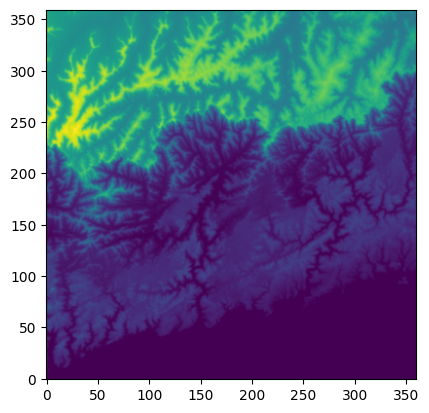

Original dataset shape: (360, 360)
Training data shapes (X, y): (5000, 2), (5000, 1)
Testing data shapes (X, y): (20000, 2), (20000, 1)
Candidate data shape (X): (150, 2)
Dataset loaded and preprocessed successfully.


2025-12-03 11:31:18.004248: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
# Load data
data = np.load("N17E073.npy")
plt.imshow(data.T, origin="lower")
plt.show()

dataset = Dataset(data=data, dtype=np.float32,
                  num_train=5000, num_test=20000)
X_train, y_train = dataset.get_train()

# Train GP/Kernel 
_, noise_variance, kernel, model = get_model_params(
    X_train=X_train, y_train=y_train, 
    kernel=get_kernel('Attentive')(lengthscales=np.linspace(1, 10, 10)),
    optimizer='tf.Nadam',
    learning_rate=1e-2,
    max_steps=1000,
    return_model=True,
    verbose=False)

In [3]:
def get_grid(X_data, num_x, num_y):
    grid_x, grid_y = np.mgrid[min(X_data[:, 0]):max(X_data[:, 0]):complex(num_x), 
                              min(X_data[:, 1]):max(X_data[:, 1]):complex(num_y)]
    X_grid = np.stack([grid_x, grid_y], axis=-1)
    return X_grid.reshape(-1, 2).astype(X_data.dtype)

In [4]:
# ---------------- Generate X_test, y_test, y_test_ls ----------------
x_dim, y_dim = 100, 100
X_test = get_grid(X_train, x_dim, y_dim)
print("Test Set Dims:", X_test.shape)
y_test, _ = model.predict_f(X_test)
y_test_ls = kernel.get_lengthscales(X_test)
y_test = y_test.numpy()

# ---------------- Generate X_cand (grid with spacing set to minimum radius) ----------------
min_r = np.min(y_test_ls/2) * 0.5
x_max, y_max = X_train.max(axis=0)
x_min, y_min = X_train.min(axis=0)

# Define the number of points in each dimension
cand_x_dim = np.ceil((x_max-x_min)/min_r).astype(int)
cand_y_dim = np.ceil((y_max-y_min)/min_r).astype(int)

X_cand = get_grid(X_train, cand_x_dim, cand_y_dim)
print("Candidate Set Dims:", X_cand.shape)

# Get the extent for potting
extent = [min(X_train[:, 0]), max(X_train[:, 0]), 
          min(X_train[:, 1]), max(X_train[:, 1])]

Test Set Dims: (10000, 2)
Candidate Set Dims: (4624, 2)


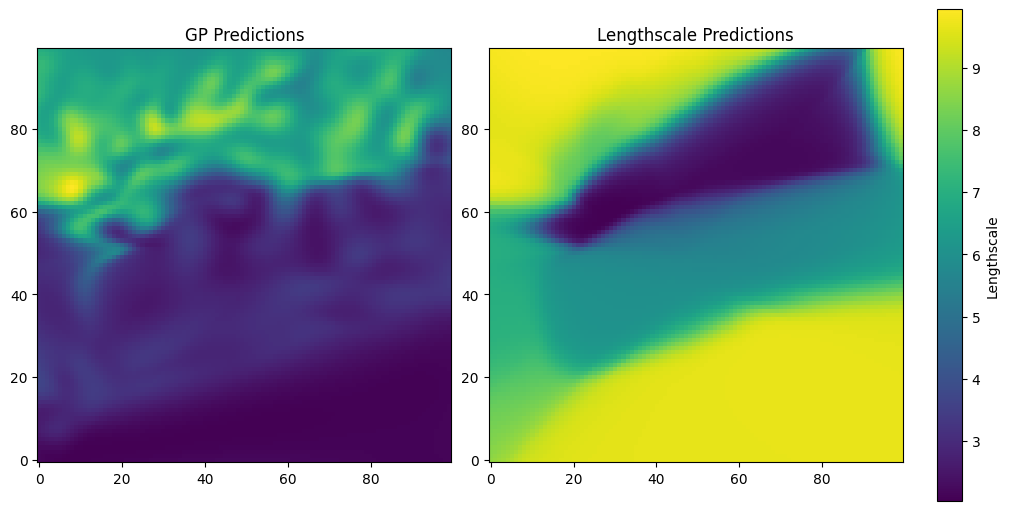

In [5]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].imshow(y_test.reshape(x_dim, y_dim).T, origin="lower")
axes[0].set_title("GP Predictions")
axes[0].set_aspect('equal')

# Second subplot — test data
sc2 = axes[1].imshow(y_test_ls.reshape(x_dim, y_dim).T, origin="lower")
axes[1].set_title("Lengthscale Predictions")
axes[1].set_aspect('equal')

# Shared colorbar
fig.colorbar(sc2, ax=axes, orientation='vertical', 
             fraction=0.05, pad=0.04, label='Lengthscale')

plt.show()

In [6]:
max_var = 0.65
kernel_threshold = np.sqrt((1.0 - max_var)*(1 + noise_variance))
print(f"Kernel Threshold: {kernel_threshold:.2f}")
cmodel = get_method('GreedyCoverage')(num_sensing=500,
                                      X_objective=X_train,
                                      kernel=kernel,
                                      noise_variance=noise_variance,
                                      X_candidates=X_cand)
X_sol = cmodel.optimize(kernel_threshold=max_var)[0]
print(f"Num Sol Points: {len(X_sol)}")

Kernel Threshold: 0.61
Num Sol Points: 91


In [7]:
y_sol, _ = model.predict_f(X_sol)
_, _, _, model_sol = get_model_params(
    X_train=X_sol, y_train=y_sol, 
    kernel=kernel,
    noise_variance=noise_variance,
    max_steps=0,
    return_model=True,
    verbose=False)
mean, var = model_sol.predict_f(X_test)
cov = kernel(X_sol, X_test).numpy()

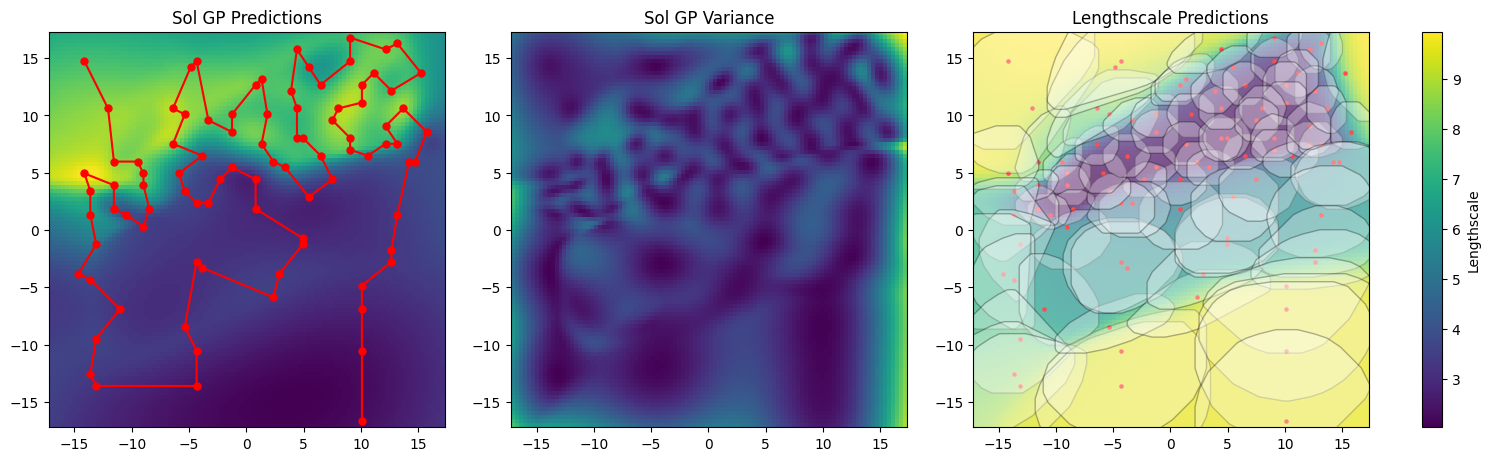

In [8]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].imshow(mean.numpy().reshape(x_dim, y_dim).T, 
                     extent=extent, origin="lower")
axes[0].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=25)
axes[0].plot(X_sol[:, 0], X_sol[:, 1], c='r')
axes[0].set_title("Sol GP Predictions")
axes[0].set_aspect('equal')

sc2 = axes[1].imshow(var.numpy().reshape(x_dim, y_dim).T, 
                     extent=extent, origin="lower")
axes[1].set_title("Sol GP Variance")
axes[1].set_aspect('equal')

sc2 = axes[2].imshow(y_test_ls.reshape(x_dim, y_dim).T,
                     extent=extent, origin="lower")
axes[2].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)

for i in range(len(X_sol)):
    idx = np.where(cov[i] > kernel_threshold)
    mask = X_test[idx]
    poly = Polygon(mask).convex_hull
    poly = poly.buffer(0.5)
    patch = MplPolygon(list(poly.exterior.coords), 
                    closed=True, 
                    facecolor='w', 
                    edgecolor='k', 
                    alpha=0.3)
    axes[2].add_patch(patch)
axes[2].set_title("Lengthscale Predictions")
axes[2].set_aspect('equal')
axes[2].set_xlim(axes[1].get_xlim())
axes[2].set_ylim(axes[1].get_ylim())

# Shared colorbar
fig.colorbar(sc2, ax=axes, orientation='vertical', 
             fraction=0.05, pad=0.04, label='Lengthscale')

plt.show()

In [9]:
max_var = 0.75
kernel_threshold = np.sqrt((1.0 - max_var)*(1 + noise_variance))
print(f"Kernel Threshold: {kernel_threshold:.2f}")
cmodel = get_method('GCBCoverage')(num_sensing=500,
                                   X_objective=X_train,
                                   kernel=kernel,
                                   noise_variance=noise_variance,
                                   X_candidates=X_sol)
X_sol = cmodel.optimize(kernel_threshold=max_var)[0]
print(f"Num Sol Points: {len(X_sol)}")

Kernel Threshold: 0.51
Num Sol Points: 76


In [10]:
y_sol, _ = model.predict_f(X_sol)
_, _, _, model_sol = get_model_params(
    X_train=X_sol, y_train=y_sol, 
    kernel=kernel,
    noise_variance=noise_variance,
    max_steps=0,
    return_model=True,
    verbose=False)
mean, var = model_sol.predict_f(X_test)
cov = kernel(X_sol, X_test).numpy()

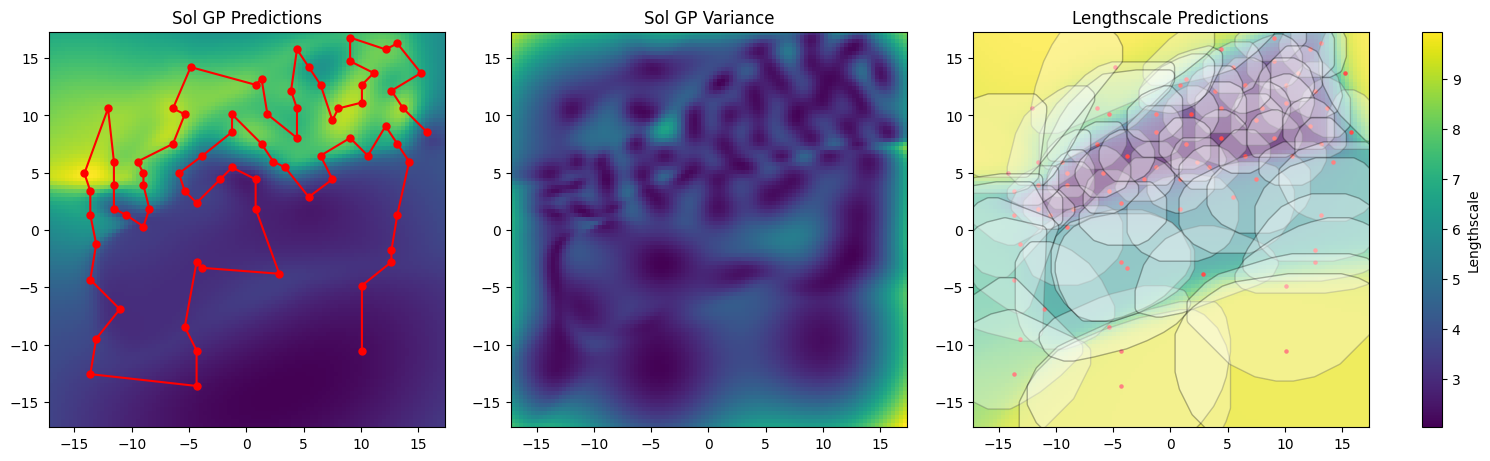

In [11]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].imshow(mean.numpy().reshape(x_dim, y_dim).T, 
                     extent=extent, origin="lower")
axes[0].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=25)
axes[0].plot(X_sol[:, 0], X_sol[:, 1], c='r')
axes[0].set_title("Sol GP Predictions")
axes[0].set_aspect('equal')

sc2 = axes[1].imshow(var.numpy().reshape(x_dim, y_dim).T, 
                     extent=extent, origin="lower")
axes[1].set_title("Sol GP Variance")
axes[1].set_aspect('equal')

sc2 = axes[2].imshow(y_test_ls.reshape(x_dim, y_dim).T,
                     extent=extent, origin="lower")
axes[2].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)

for i in range(len(X_sol)):
    idx = np.where(cov[i] > kernel_threshold)
    mask = X_test[idx]
    poly = Polygon(mask).convex_hull
    poly = poly.buffer(0.5)
    patch = MplPolygon(list(poly.exterior.coords), 
                    closed=True, 
                    facecolor='w', 
                    edgecolor='k', 
                    alpha=0.3)
    axes[2].add_patch(patch)
axes[2].set_title("Lengthscale Predictions")
axes[2].set_aspect('equal')
axes[2].set_xlim(axes[1].get_xlim())
axes[2].set_ylim(axes[1].get_ylim())

# Shared colorbar
fig.colorbar(sc2, ax=axes, orientation='vertical', 
             fraction=0.05, pad=0.04, label='Lengthscale')

plt.show()